In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from math import pi

In [104]:
# submit_record = pd.read_csv('path_to_your_data.csv')

relative_path = '../../sourcedata/'

# 读取题目信息 title = 题目
title_info = pd.read_csv(relative_path + 'Data_TitleInfo.csv')

# 读取学生信息 student = 学生
student_info = pd.read_csv(relative_path + 'Data_StudentInfo.csv')
# 统计每个知识点的题目数量，以字典形式存储
knowledge_count = title_info['knowledge'].value_counts().to_dict()
print(knowledge_count)

# 读取学生答题记录
submit_record = pd.read_csv(relative_path + 'All_Class/all_class_submit_record.csv')

{'m3D1v': 12, 'y9W5d': 11, 'r8S3g': 6, 't5V9e': 5, 'g7R2j': 5, 'b3C9s': 3, 'k4W1c': 1, 's8Y2f': 1}


In [105]:
# 将时间戳转换为日期时间格式
submit_record['time'] = pd.to_datetime(submit_record['time'], unit='s')

# 提取时间特征
submit_record['hour'] = submit_record['time'].dt.hour # 0-23
submit_record['day'] = submit_record['time'].dt.day # 1-31
# submit_record['weekday'] = submit_record['time'].dt.weekday # 0-6, 0 is Monday
# submit_record['week'] = submit_record['time'].dt.week # 1-52 没有这个属性
submit_record['month'] = submit_record['time'].dt.month # 1-12
# submit_record['weekday_name'] = submit_record['time'].dt.weekday_name # Monday, Tuesday, ...
# print(submit_record.iloc[50:100,16:20])

# 按时间特征统计答题量
hourly_data = submit_record.groupby('hour').size()
daily_data = submit_record.groupby('day').size()
# weekly_data = submit_record.groupby('weekday').size()
monthly_data = submit_record.groupby('month').size()


In [106]:
# 答题正确率
submit_record['is_correct'] = submit_record['state'].apply(lambda x: 1 if x == 'Absolutely_Correct' else 0)

# 计算每个学生的每个1级知识点总的尝试次数
submit_record['attempts_per_kg'] = submit_record.groupby(['student_ID', 'knowledge'])['index'].transform('count')
# 转换为宽格式 aggfunc='first' 聚合函数，用于处理重复的索引值，first表示取第一个值 pivot_table()函数用于数据透视表
knowledge_pivot = submit_record.pivot_table(index='student_ID', columns='knowledge', values='attempts_per_kg', aggfunc='mean').fillna(0)
# 每种知识点的尝试次数除以该知识点的题目数量，得到每种知识点的平均尝试次数
knowledge_pivot = knowledge_pivot / knowledge_pivot.columns.map(knowledge_count)
# 重命名列名（可选）
knowledge_pivot.columns = [f'attempts_{col}' for col in knowledge_pivot.columns]
# print('knowledge_pivot:\n', knowledge_pivot)


# 计算特征
features = submit_record.groupby('student_ID').agg({
    # 'score': ['mean', 'sum', 'count'],
    # 'score': 'sum',
    # 'is_correct': 'mean',# 计算每个学生每次提交的平均正确率，意义不大。而计算最终题目的正确率与后续单个知识点的正确率有有重叠，所以不需要
    # 'timeconsume': 'mean',
    # 'memory': 'mean',
    'hour': lambda x: x.value_counts().idxmax(), # 最常答题的时间段 匿名函数作用是返回出现次数最多的值 .value_counts()统计每个值出现的次数 .idxmax()返回出现次数最多的值
    'method': lambda x: x.value_counts().idxmax(), # 最常用的方法
    # 'title_ID': 'nunique', # 不同题目数量 尝试的题目数量
    # 'major': 'first',
})

# 这行代码的作用是将多级列索引转换为单级索引，并且分配容易理解的列名。
features.columns = [
    # 'score_mean', 'score_sum', 'score_count', 
    # 'score_sum', 
    # 'correct_rate', 
    # 'avg_timeconsume', 'avg_memory', 
    'most_common_hour', 
    'most_common_method', 
    # 'unique_questions'
    # 'major',
]

# 学生的活跃天数，需要注意答题记录中包含5个月的数据
temple_submit_record = submit_record.drop_duplicates(subset=['student_ID', 'month','day'], keep='first')
features['active_days'] = temple_submit_record.groupby('student_ID')['day'].count()
# print(features['active_days'][:100])
# 每个学生的答题时长 可能与题目尝试次数相关
temple_submit_record = submit_record.drop_duplicates(subset=['student_ID', 'month','day','hour'], keep='first')
features['learn_hours'] = temple_submit_record.groupby('student_ID')['hour'].count()

# 每道题目对应知识点最终得分率
submit_record = submit_record.sort_values(by=['student_ID', 'title_ID', 'knowledge','score'], ascending=[True, True, True, False])
submit_record = submit_record.drop_duplicates(subset=['student_ID', 'title_ID', 'knowledge'], keep='first')
submit_record['score_ratio'] = submit_record['score'] / submit_record['full_score']
# 每个学生每个知识点的平均得分率
submit_record['score_ratio_per_kg'] = submit_record.groupby(['student_ID', 'knowledge'])['score_ratio'].transform('mean')
score_pivot = submit_record.pivot_table(index='student_ID', columns='knowledge', values='score_ratio_per_kg', aggfunc='first').fillna(0)
score_pivot.columns = [f'score_ratio_{col}' for col in score_pivot.columns]

# 计算学生总的得分
submit_record = submit_record.sort_values(by=['student_ID', 'title_ID', 'score'], ascending=[True, True, False])
submit_record = submit_record.drop_duplicates(subset=['student_ID', 'title_ID'], keep='first')
features['total_score'] = submit_record.groupby('student_ID')['score'].sum()


# 合并到特征表 how='left'表示左连接,左连接表示以左表为基础，右表中的数据只要在左表中有对应的就会被合并到一起，没有对应的就会被舍弃。
# fillna(0)表示将缺失值填充为0
features = features.merge(knowledge_pivot, on='student_ID', how='left').fillna(0)
features = features.merge(score_pivot, on='student_ID', how='left').fillna(0)

# 编码分类特征 .astype('category')表示将数据转换为分类数据，.cat.codes表示将分类数据转换为数值数据 
# 通过这种方式可以将分类数据转换为数值数据
# 对于某些非数值型特征（如小时、方法），我们需要将其转换为数值型以便于聚类分析。
# 作用是将最常答题的小时从类别类型转换为数值型编码。
features['most_common_hour'] = features['most_common_hour'].astype('category').cat.codes
features['most_common_method'] = features['most_common_method'].astype('category').cat.codes
# features['major'] = features['major'].astype('category').cat.codes


# 对特征进行标准化
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(features)

# # 使用KMeans进行聚类
# kmeans = KMeans(n_clusters=3, random_state=42, init='k-means++', algorithm='lloyd', n_init='auto')
# features['cluster'] = kmeans.fit_predict(scaled_features)

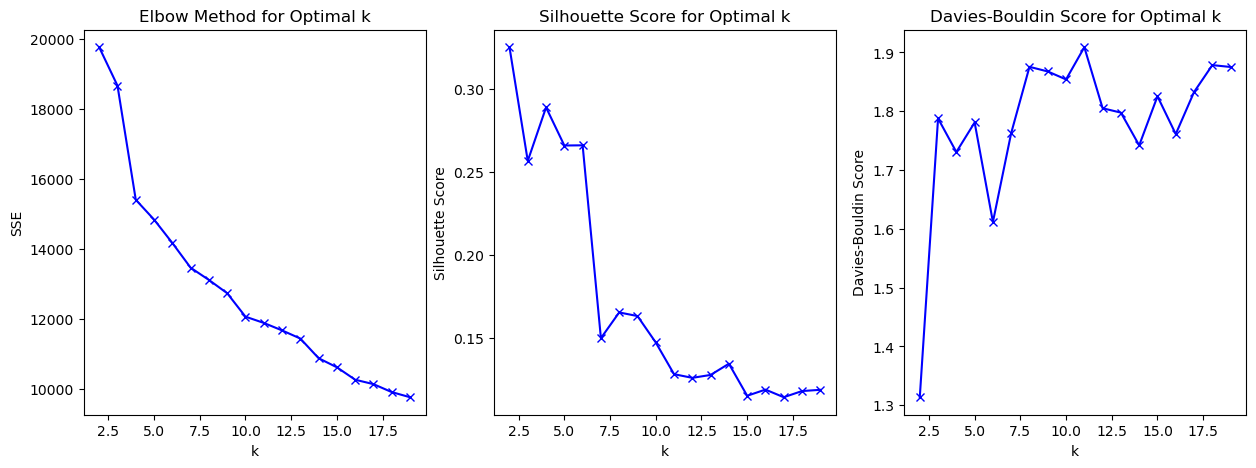

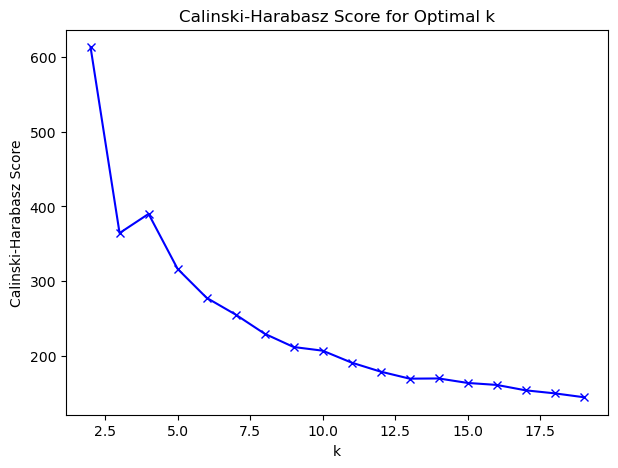

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# 数据标准化
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 肘部法
sse = []
silhouette_scores = []
db_scores = []
ch_scores = []

K = range(2, 20)
for k in K:
    # kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', algorithm='lloyd', n_init='auto')
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))
    db_scores.append(davies_bouldin_score(scaled_features, kmeans.labels_))
    ch_scores.append(calinski_harabasz_score(scaled_features, kmeans.labels_))

# 绘制肘部法图 拐点
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')

# 绘制轮廓系数图 [-1,1]之间，越接近1越好
plt.subplot(1, 3, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

# 绘制Davies-Bouldin指数图 越小越好
plt.subplot(1, 3, 3)
plt.plot(K, db_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score for Optimal k')

plt.show()

# 绘制Calinski-Harabasz指数图 越大越好
plt.figure(figsize=(7, 5))
plt.plot(K, ch_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score for Optimal k')
plt.show()


In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

num_clusters = 5
num_clusters = 6
# num_clusters = 7
# num_clusters = 8
# num_clusters = 10
# 标准化特征
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
# KMeans
# kmeans = KMeans(n_clusters=15, random_state=42)
kmeans = KMeans(n_clusters=num_clusters, random_state=42, init='k-means++', algorithm='lloyd', n_init='auto')
features['kmeans_cluster'] = kmeans.fit_predict(scaled_features)
print('kmeans_cluster:',features['kmeans_cluster'].max())

# 层次聚类
hierarchical = AgglomerativeClustering(n_clusters=num_clusters)
features['hierarchical_cluster'] = hierarchical.fit_predict(scaled_features)
print('hierarchical_cluster:',features['hierarchical_cluster'].max())

# DBSCAN 难以调节参数 效果不好
# dbscan = DBSCAN(eps=2, min_samples=10)
# features['dbscan_cluster'] = dbscan.fit_predict(scaled_features)
# print('dbscan_cluster:',features['dbscan_cluster'].max())

# 谱聚类 慢
# spectral = SpectralClustering(n_clusters=3, random_state=42)
# features['spectral_cluster'] = spectral.fit_predict(scaled_features)
# 高斯混合模型
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
features['gmm_cluster'] = gmm.fit_predict(scaled_features)
print('gmm_cluster:',features['gmm_cluster'].max())



kmeans_cluster: 5
hierarchical_cluster: 5
gmm_cluster: 5


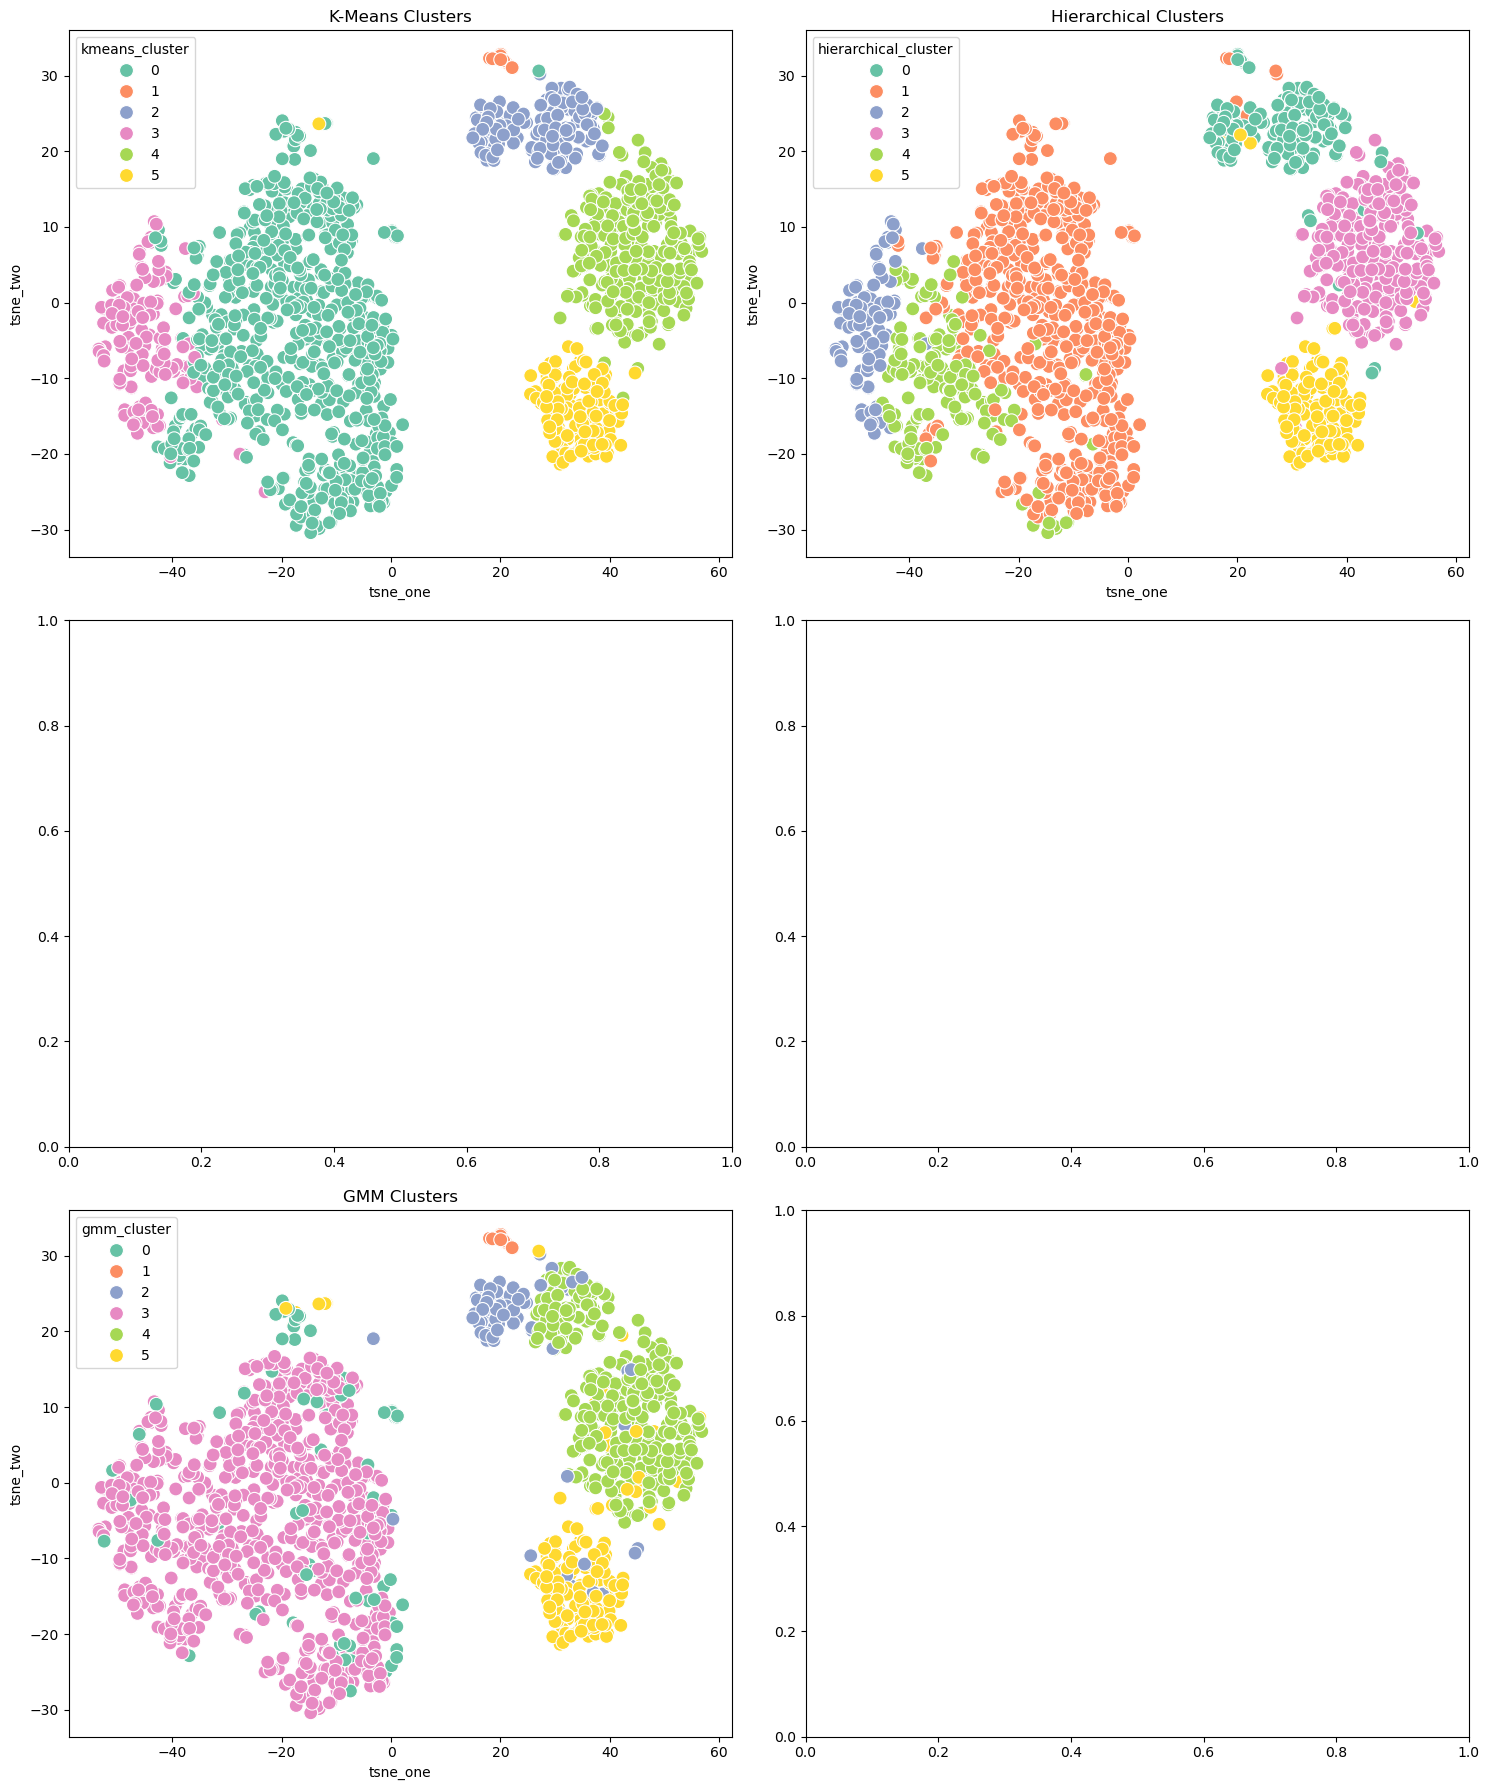

In [91]:
# 降维
# t-SNE降维
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)

# 添加t-SNE结果到features中
features['tsne_one'] = tsne_features[:, 0]
features['tsne_two'] = tsne_features[:, 1]

# 绘制不同聚类算法的t-SNE可视化结果
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# 绘制K-Means聚类结果
sns.scatterplot(data=features, x='tsne_one', y='tsne_two', hue='kmeans_cluster', palette='Set2',s=100, ax=axes[0, 0])
axes[0, 0].set_title('K-Means Clusters')

# 绘制层次聚类结果
sns.scatterplot(data=features, x='tsne_one', y='tsne_two', hue='hierarchical_cluster', palette='Set2', s=100, ax=axes[0, 1])
axes[0, 1].set_title('Hierarchical Clusters')

# 绘制DBSCAN聚类结果
# sns.scatterplot(data=features, x='tsne_one', y='tsne_two', hue='dbscan_cluster', palette='Set2', s=100, ax=axes[1, 0])
# axes[1, 0].set_title('DBSCAN Clusters')

# # 绘制谱聚类结果
# sns.scatterplot(data=features, x='tsne_one', y='tsne_two', hue='spectral_cluster', palette='Set2', s=100, ax=axes[1, 1])
# axes[1, 1].set_title('Spectral Clusters')

# 绘制GMM聚类结果
sns.scatterplot(data=features, x='tsne_one', y='tsne_two', hue='gmm_cluster',palette='Set2', s=100, ax=axes[2, 0])
axes[2, 0].set_title('GMM Clusters')

plt.tight_layout()
plt.show()

['most_common_hour' 'most_common_method' 'active_days' 'learn_hours'
 'total_score' 'attempts_b3C9s' 'attempts_g7R2j' 'attempts_k4W1c'
 'attempts_m3D1v' 'attempts_r8S3g' 'attempts_s8Y2f' 'attempts_t5V9e'
 'attempts_y9W5d' 'score_ratio_b3C9s' 'score_ratio_g7R2j'
 'score_ratio_k4W1c' 'score_ratio_m3D1v' 'score_ratio_r8S3g'
 'score_ratio_s8Y2f' 'score_ratio_t5V9e' 'score_ratio_y9W5d'
 'kmeans_cluster' 'gmm_cluster']
cluster_centers: 99.77914110429448 120.47826086956522 64.203007518797


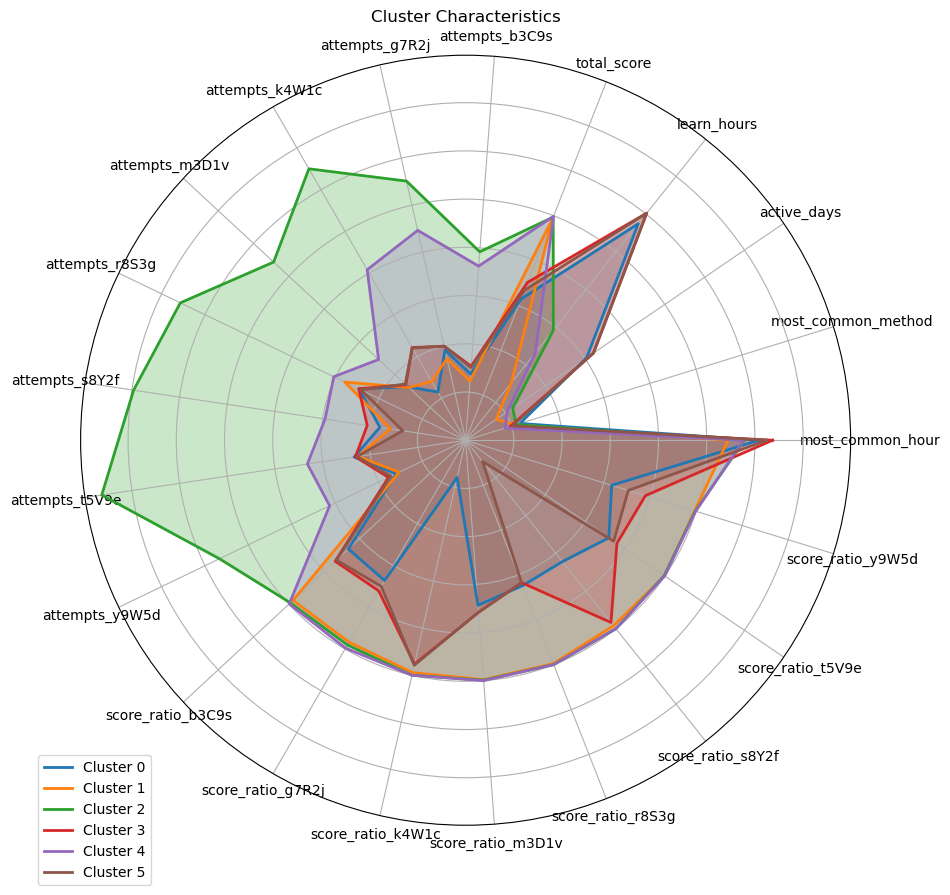

In [102]:
# 聚类结果可视化
# 绘图函数
def plot_radar_chart(cluster_centers, title):

    categories = cluster_centers.columns.tolist()
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    for i, row in cluster_centers.iterrows():
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title(title)
    plt.show()

# 聚类中心点
cluster_centers = features.groupby('hierarchical_cluster').mean()
print(cluster_centers.columns.values)
print('cluster_centers:',cluster_centers['total_score'].max(),cluster_centers['learn_hours'].max(),cluster_centers['active_days'].max())
cluster_centers = cluster_centers.drop(['kmeans_cluster', 'gmm_cluster'], axis=1)
cluster_centers['total_score'] = cluster_centers['total_score'] / 10
cluster_centers['learn_hours'] = cluster_centers['learn_hours'] / 10
cluster_centers['active_days'] = cluster_centers['active_days'] / 10
cluster_centers.iloc[:, 13:22] = cluster_centers.iloc[:, 13:22] * 10
plot_radar_chart(cluster_centers, 'Cluster Characteristics')

In [107]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 假设df是包含所有特征和目标变量的数据框
featuresX = features[['most_common_hour', 'most_common_method', 'active_days', 'learn_hours',
               'attempts_b3C9s', 'attempts_g7R2j', 'attempts_k4W1c',
               'attempts_m3D1v', 'attempts_r8S3g', 'attempts_s8Y2f',
               'attempts_t5V9e', 'attempts_y9W5d', 'score_ratio_b3C9s',
               'score_ratio_g7R2j', 'score_ratio_k4W1c', 'score_ratio_m3D1v',
               'score_ratio_r8S3g', 'score_ratio_s8Y2f', 'score_ratio_t5V9e',
               'score_ratio_y9W5d']]
target = features['total_score']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(featuresX)

X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

# 使用线性回归模型
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

print('Linear Regression Mean Squared Error:', mean_squared_error(y_test, y_pred_linear))
print('Linear Regression R2 Score:', r2_score(y_test, y_pred_linear))

# 使用随机森林回归模型
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print('Random Forest Mean Squared Error:', mean_squared_error(y_test, y_pred_rf))
print('Random Forest R2 Score:', r2_score(y_test, y_pred_rf))


Linear Regression Mean Squared Error: 11.900065707163462
Linear Regression R2 Score: 0.9593654654613243
Random Forest Mean Squared Error: 13.659966666666666
Random Forest R2 Score: 0.953356023321813


In [108]:

# 线性回归模型解释
# 线性回归的解释较为直接，通过查看回归系数，可以了解每个特征对总分的影响。
# 一个线性回归模型的系数
coefficients = linear_model.coef_
# 创建一个 DataFrame 来展示特征及其对应的系数
feature_importance = pd.DataFrame({'Feature': featuresX.columns, 'Coefficient': coefficients})
print(feature_importance.sort_values(by='Coefficient', ascending=False))

# 随机森林回归模型解释
# 随机森林的解释通过特征重要性来完成，特征重要性反映了每个特征对模型预测的贡献。
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': featuresX.columns, 'Importance': importances})
print(feature_importance.sort_values(by='Importance', ascending=False))


               Feature  Coefficient
19   score_ratio_y9W5d     5.729388
15   score_ratio_m3D1v     4.404273
13   score_ratio_g7R2j     3.722066
12   score_ratio_b3C9s     2.451139
18   score_ratio_t5V9e     1.828678
16   score_ratio_r8S3g     1.037124
3          learn_hours     0.473266
17   score_ratio_s8Y2f     0.438719
5       attempts_g7R2j     0.151080
7       attempts_m3D1v     0.105792
10      attempts_t5V9e     0.052750
8       attempts_r8S3g     0.036601
6       attempts_k4W1c     0.036372
9       attempts_s8Y2f     0.022362
1   most_common_method    -0.004694
14   score_ratio_k4W1c    -0.012723
4       attempts_b3C9s    -0.018261
11      attempts_y9W5d    -0.025610
0     most_common_hour    -0.129112
2          active_days    -1.176295
               Feature  Importance
19   score_ratio_y9W5d    0.831288
15   score_ratio_m3D1v    0.066569
11      attempts_y9W5d    0.031968
13   score_ratio_g7R2j    0.013239
7       attempts_m3D1v    0.013237
12   score_ratio_b3C9s    0.009980